['biden-original.wav', 'linus-original.wav', 'margot-original.wav', 'musk-original.wav', 'obama-original.wav', 'ryan-original.wav', 'taylor-original.wav', 'trump-original.wav']
Real Audio Files:
['biden-original.wav', 'linus-original.wav', 'margot-original.wav', 'musk-original.wav', 'obama-original.wav', 'ryan-original.wav', 'taylor-original.wav', 'trump-original.wav']

Fake Audio Files:
['biden-to-linus.wav', 'biden-to-margot.wav', 'biden-to-musk.wav', 'biden-to-Obama.wav', 'biden-to-ryan.wav', 'biden-to-taylor.wav', 'biden-to-Trump.wav', 'linus-to-biden.wav', 'linus-to-margot.wav', 'linus-to-musk.wav', 'linus-to-obama.wav', 'linus-to-ryan.wav', 'linus-to-taylor.wav', 'linus-to-trump.wav', 'margot-to-biden.wav', 'margot-to-linus.wav', 'margot-to-musk.wav', 'margot-to-obama.wav', 'margot-to-ryan.wav', 'margot-to-taylor.wav', 'margot-to-trump.wav', 'musk-to-biden.wav', 'musk-to-linus.wav', 'musk-to-margot.wav', 'musk-to-obama.wav', 'musk-to-ryan.wav', 'musk-to-taylor.wav', 'musk-to-trum

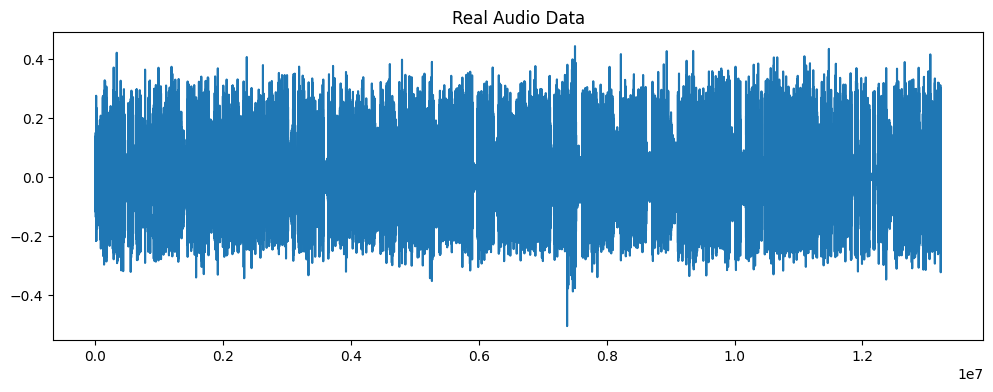

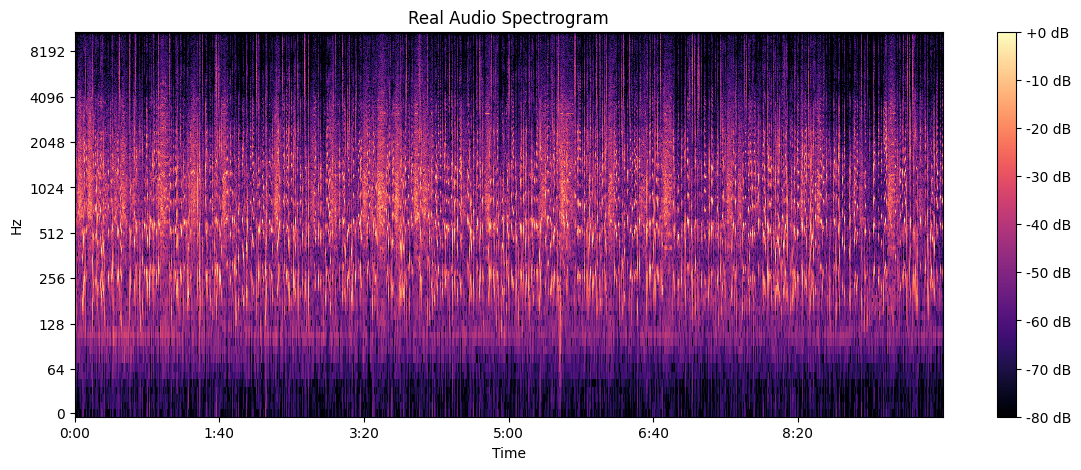

Fake Audio File Path: C:\Users\Soham Sarwadhikari\Dropbox\PC\Downloads\KAGGLE\AUDIO\FAKE\biden-to-linus.wav


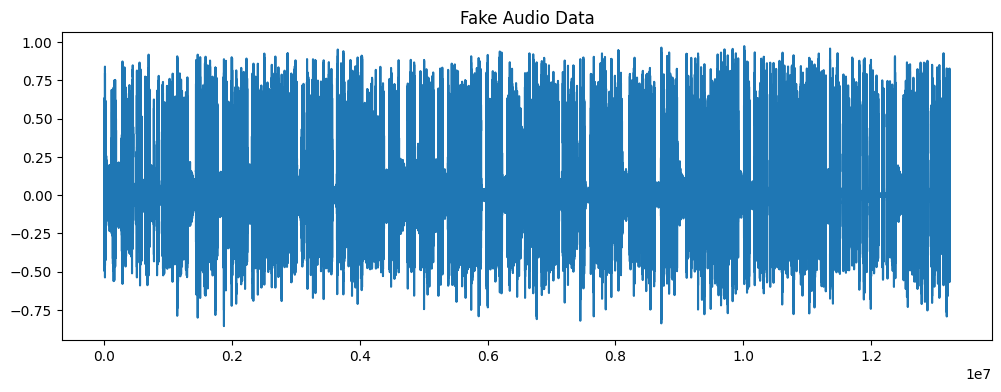

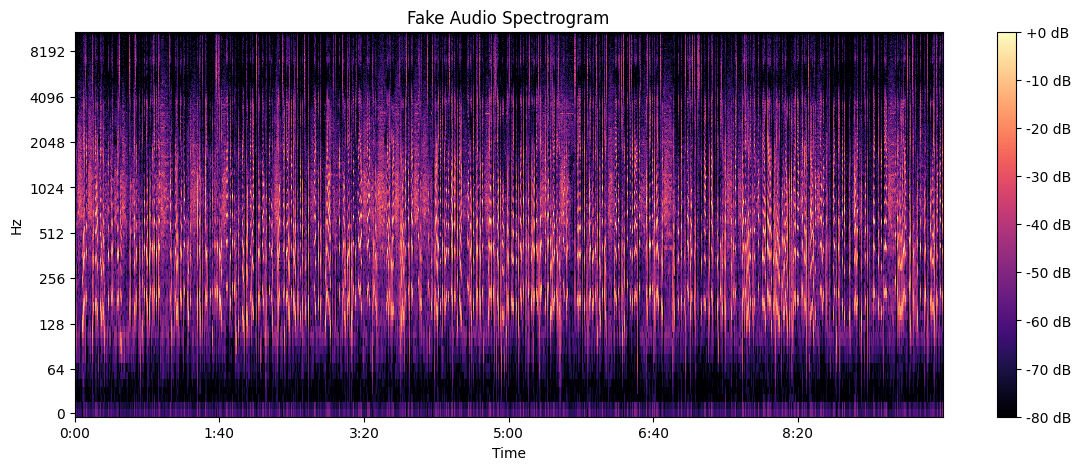

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\Soham Sarwadhikari\\Dropbox\\PC\\Downloads\\KAGGLE\\AUDIO\\REAL\\biden-original.wav'

In [12]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Suppressing the warning related to PySoundFile
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

# Define the path to the audio files
audio_files_path = r"C:\Users\Soham Sarwadhikari\Dropbox\PC\Downloads\KAGGLE\AUDIO"

# List the folders in the REAL directory
folders = os.listdir(os.path.join(audio_files_path, "REAL"))
print(folders)

# Define the paths to REAL and FAKE directories
real_audio = os.path.join(audio_files_path, "REAL")
fake_audio = os.path.join(audio_files_path, "FAKE")

real_files = os.listdir(real_audio)
fake_files = os.listdir(fake_audio)

print("Real Audio Files:")
print(real_files)

print("\nFake Audio Files:")
print(fake_files)


# Load and visualize real audio data
real_file_path = os.path.join(real_audio, real_files[0])
print("Real Audio File Path:", real_file_path)
real_ad, real_sr = librosa.load(real_file_path)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

# Visualize real audio spectrogram
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectrogram")
plt.show()

# Load and visualize fake audio data
fake_file_path = os.path.join(fake_audio, fake_files[0])
print("Fake Audio File Path:", fake_file_path)
fake_ad, fake_sr = librosa.load(fake_file_path)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

# Visualize fake audio spectrogram
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectrogram")
plt.show()

# Feature extraction and data preprocessing
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(real_audio, folder))
    for file in tqdm(files):
        file_path = os.path.join(real_audio, folder, file)
        audio, sample_rate = librosa.load(file_path)
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)
## Create a DataFrame with features and labels
feature_df = pd.DataFrame({"features": data, "class": labels})

# Encode class labels
le = LabelEncoder().fit(feature_df["class"])
feature_df["class"] = le.transform(feature_df["class"])

# Prepare input and output data for the model
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

# Resample data to address class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled = to_categorical(y_resampled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define model architecture
num_labels = len(feature_df["class"].unique())
input_shape = feature_df["features"][0].shape

model = Sequential([
    Dense(128, input_shape=input_shape),
    Activation("relu"),
    Dropout(0.5),
    Dense(256),
    Activation("relu"),
    Dropout(0.5),
    Dense(128),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_labels),
    Activation("softmax")
])

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Display model summary
model.summary()

# Define early stopping callback
early = EarlyStopping(monitor="val_loss", patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100, callbacks=[early])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Plot model accuracy over epochs
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot model loss over epochs
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()
# Plot model loss over epochs
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Function to detect fake audio
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

# Test fake audio detection
test_real = os.path.join(real_audio, os.listdir(real_audio)[0])
test_fake = os.path.join(fake_audio, os.listdir(fake_audio)[0])

detect_fake(test_real)
detect_fake(test_fake)


In [6]:
pip install resampy

Note: you may need to restart the kernel to use updated packages.Collecting resampy
     ---------------------------------------- 3.1/3.1 MB 4.5 MB/s eta 0:00:00




[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
pip install tensorflow

     -------------------------------------- 377.0/377.0 MB 2.0 MB/s eta 0:00:00
     -------------------------------------- 133.7/133.7 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 26.4/26.4 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 127.7/127.7 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 65.8

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
pip install imblearn

     -------------------------------------- 257.7/257.7 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install numpy

     -------------------------------------- 15.8/15.8 MB 953.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
python.exe -m pip install --upgrade pip

SyntaxError: invalid syntax (842801469.py, line 1)

In [12]:
pip install pandas

     ---------------------------------------- 11.6/11.6 MB 1.1 MB/s eta 0:00:00
     ------------------------------------ 505.5/505.5 kB 792.4 kB/s eta 0:00:00
     -------------------------------------- 345.4/345.4 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install librosa

     ------------------------------------ 253.7/253.7 kB 973.9 kB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 10.6/10.6 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 63.0/63.0 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 184.7/184.7 kB 2.8 MB/s eta 0:00:00
  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
     ---------------------------------------- 75.2/75.2 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 28.1/28.1 MB 2.6 MB/s eta 0:00:00
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
     -------------------------------------- 181.5/181.5 kB 3.6 MB/s eta 0:00:00
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 187.6/187.6 kB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 3.3 MB/s eta 0:00:00
     -------------------------------------- 103.2/103.2 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
pip install seaborn

     -------------------------------------- 294.9/294.9 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
pip install tqdm

     -------------------------------------- 78.3/78.3 kB 312.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
